
## PART I: DATA SCRAPING

In [1]:
import numpy as np
from selenium import webdriver
from time import sleep
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
import pandas as pd

In [2]:
# Declare browser

from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

# Set path to ChromeDriver
service = Service('chromedriver.exe')

# Optional: set Chrome options
options = Options()

# Create driver instance
driver = webdriver.Chrome(service=service, options=options) # it will pops-up real chrome


In [3]:
# Open URL in the controlled chrome browser
driver.get("https://www.youtube.com/@coles/videos")

In [ ]:
#CAN GET SOME INFO OF THE CHANNEL (I.E TOTAL SUBCRIBER/TOTAL VIDEOS) - NO NEED SCROLL DOWN

In [23]:
# DEFINE FUNCTION TO LOOP THROUGH(SCROLL DOWN) TIL THE END - to extract link
def scroll_to_bottom(driver):
    last_height = driver.execute_script("return document.documentElement.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        sleep(80) #pause 1min before scrolling down #SLOW BUT WORKS WELL TO CAPTURE THE ALL DATA
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

In [15]:
# Scroll to load all videos
scroll_to_bottom(driver)

#EXTRACT LINKS OF VIDEOS
# <a id="video-title-link" clas ... href="..."> 
#   <yt-formatted-string class="style-scope ytd-video-renderer">Actual Video Title</yt-formatted-string>

# Extract all video <a> elements by id="video-title-link"
title_links = driver.find_elements(By.CSS_SELECTOR, "a#video-title-link")

# Extract all visible titles
titles = [elem.text for elem in title_links]

# Extract all href links
links = [elem.get_attribute('href') for elem in title_links]

#MAKE IT INTO DATAFRAME
df1 = pd.DataFrame(list(zip(titles, links)), columns = ['title', 'link_video'])
df1['index_']= np.arange(1, len(df1) + 1) 

In [16]:
df1

,title,link_video,index_
0,Curtis Stone’s Ultimate Steak Guide | Cook wit...,https://www.youtube.com/watch?v=Hgyr8NME5x8&pp...,1
1,Chrissie Swan’s green chicken | What’s for Din...,https://www.youtube.com/watch?v=JPa4vWKZiEw,2
2,Curtis Stone’s best ever lasagne | Cook with C...,https://www.youtube.com/watch?v=PCQus_d0dmw,3
3,Curtis Stone’s best ever eggplant parmigiana |...,https://www.youtube.com/watch?v=UkEmBnwCnUo&pp...,4
4,Curtis Stone’s best ever beef burger | Cook wi...,https://www.youtube.com/watch?v=beJE0aJhPeU,5
...,...,...,...
1077,Homemade Apple Chips in the Oven | Cook with C...,https://www.youtube.com/watch?v=uamT7M-gwsU,1078
1078,A Chef's Guide on How to Use a Mandoline | Coo...,https://www.youtube.com/watch?v=m21TQUx3eRg,1079
1079,How to Make a Lattice Pie Crust | Cook with Cu...,https://www.youtube.com/watch?v=P7oIkbAsxig,1080
1080,AT HOME WITH COLES,https://www.youtube.com/watch?v=UbPzoXkcdmw,1081


In [66]:
#GET GENERAL INFO FOR VIDEOS
# Store results
video_data = []

for link in df1['link_video']:
    try:
        driver.get(link)
        sleep(5)

        # Extract likes
        try:
            like_button = driver.find_element(By.CSS_SELECTOR,
                "#top-level-buttons-computed > segmented-like-dislike-button-view-model > yt-smartimation > div > div > like-button-view-model > toggle-button-view-model > button-view-model > button > div.yt-spec-button-shape-next__button-text-content")
            likes = like_button.text.strip()
        except NoSuchElementException:
            likes = "N/A"
            
        #Extract lengths
        # Move mouse to video cauz only that the time will appear 
        #CONFLICT WITH THE ACTUAL MOUSE THUS CAN'T MOVE MOUSE WHILE RUNNING THIS LINE OF CODE
        ActionChains(driver).move_to_element(driver.find_element(By.CSS_SELECTOR, 
                                                                 "#movie_player > div.ytp-chrome-bottom > div.ytp-chrome-controls > div.ytp-left-controls > div.ytp-time-display.notranslate > span.ytp-time-wrapper > div > span.ytp-time-duration")).perform()

        try:
            length_elem = driver.find_element(By.CSS_SELECTOR , 
                "#movie_player > div.ytp-chrome-bottom > div.ytp-chrome-controls > div.ytp-left-controls > div.ytp-time-display.notranslate > span.ytp-time-wrapper > div > span.ytp-time-duration")
            length = length_elem.text
        except Exception:
            length = "N/A"
        
    #SCROLL DOWN TO FIND MORE BUTTON & COMMENT       
        driver.execute_script("window.scrollTo(0, 300);")
        sleep(3)
        
        # Extract total comments
        try:
            comment_elem = driver.find_element(By.CSS_SELECTOR, "#count yt-formatted-string")
            total_comments = comment_elem.text.strip()
        except Exception:
            total_comments = "N/A"
            
        # Expand description to get views & date
        try:
            more_btn = driver.find_element("xpath", "/html/body/ytd-app/div[1]/ytd-page-manager/ytd-watch-flexy/div[5]/div[1]/div/div[2]/ytd-watch-metadata/div/div[4]/div[1]/div/ytd-text-inline-expander/tp-yt-paper-button[1]")
            more_btn.click()
            sleep(3)
        except Exception:
            pass

        # Extract views and published date
        try:
            views_elem = driver.find_element(By.CSS_SELECTOR, "#info > span:nth-child(1)")
            views = views_elem.text
            
            date_elem = driver.find_element(By.CSS_SELECTOR, "#info > span:nth-child(3)")
            date = date_elem.text
            
        except Exception:
            views, date = "N/A", "N/A"

        # Save data
        video_data.append({
            'link': link,
            'views': views,
            'published_date': date,
            'likes': likes,
            'total_comments': total_comments,
            'length': length
        })

    except ElementNotInteractableException:
        print(f"Element not interactable for {link}, skipping...")
        continue
    except Exception as e:
        print(f"Error for {link}: {e}")
        continue
df2 = pd.DataFrame(video_data)

Error for https://www.youtube.com/watch?v=OnkgUBCE1Bk: HTTPConnectionPool(host='localhost', port=61791): Read timed out. (read timeout=120)
Error for https://www.youtube.com/watch?v=4lbOhNbAkCo: Message: invalid session id; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#invalidsessionidexception
Stacktrace:
	GetHandleVerifier [0x0x7ff7af44e415+77285]
	GetHandleVerifier [0x0x7ff7af44e470+77376]
	(No symbol) [0x0x7ff7af21989c]
	(No symbol) [0x0x7ff7af2610f6]
	(No symbol) [0x0x7ff7af2622b3]
	GetHandleVerifier [0x0x7ff7af731efd+3107021]
	GetHandleVerifier [0x0x7ff7af72c29d+3083373]
	GetHandleVerifier [0x0x7ff7af74bedd+3213485]
	GetHandleVerifier [0x0x7ff7af46884e+184862]
	GetHandleVerifier [0x0x7ff7af47055f+216879]
	GetHandleVerifier [0x0x7ff7af457084+113236]
	GetHandleVerifier [0x0x7ff7af457239+113673]
	GetHandleVerifier [0x0x7ff7af43e298+11368]
	BaseThreadInitThunk [0x0x7ffc261b7e94+20]
	RtlUserThreadStart [0x0x7ffc2

Error for https://www.youtube.com/watch?v=IpvJzn9GUCk: Message: invalid session id; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#invalidsessionidexception
Stacktrace:
	GetHandleVerifier [0x0x7ff7af44e415+77285]
	GetHandleVerifier [0x0x7ff7af44e470+77376]
	(No symbol) [0x0x7ff7af21989c]
	(No symbol) [0x0x7ff7af26064f]
	(No symbol) [0x0x7ff7af2984d2]
	(No symbol) [0x0x7ff7af292fd3]
	(No symbol) [0x0x7ff7af292099]
	(No symbol) [0x0x7ff7af1e4895]
	GetHandleVerifier [0x0x7ff7af731efd+3107021]
	GetHandleVerifier [0x0x7ff7af72c29d+3083373]
	GetHandleVerifier [0x0x7ff7af74bedd+3213485]
	GetHandleVerifier [0x0x7ff7af46884e+184862]
	GetHandleVerifier [0x0x7ff7af47055f+216879]
	(No symbol) [0x0x7ff7af1e3890]
	GetHandleVerifier [0x0x7ff7af866558+4370216]
	BaseThreadInitThunk [0x0x7ffc261b7e94+20]
	RtlUserThreadStart [0x0x7ffc28271af1+33]

Error for https://www.youtube.com/watch?v=tckWK_XWesM: Message: invalid session id; For

Error for https://www.youtube.com/watch?v=Cf8rj0LLY6E: Message: invalid session id; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#invalidsessionidexception
Stacktrace:
	GetHandleVerifier [0x0x7ff7af44e415+77285]
	GetHandleVerifier [0x0x7ff7af44e470+77376]
	(No symbol) [0x0x7ff7af21989c]
	(No symbol) [0x0x7ff7af26064f]
	(No symbol) [0x0x7ff7af2984d2]
	(No symbol) [0x0x7ff7af292fd3]
	(No symbol) [0x0x7ff7af292099]
	(No symbol) [0x0x7ff7af1e4895]
	GetHandleVerifier [0x0x7ff7af731efd+3107021]
	GetHandleVerifier [0x0x7ff7af72c29d+3083373]
	GetHandleVerifier [0x0x7ff7af74bedd+3213485]
	GetHandleVerifier [0x0x7ff7af46884e+184862]
	GetHandleVerifier [0x0x7ff7af47055f+216879]
	(No symbol) [0x0x7ff7af1e3890]
	GetHandleVerifier [0x0x7ff7af866558+4370216]
	BaseThreadInitThunk [0x0x7ffc261b7e94+20]
	RtlUserThreadStart [0x0x7ffc28271af1+33]

Error for https://www.youtube.com/watch?v=mi7kNQzbkVM: Message: invalid session id; For

In [69]:
df2 #due to timeout error #took 477 out

,link,views,published_date,likes,total_comments,length
0,https://www.youtube.com/watch?v=Hgyr8NME5x8&pp...,378 views,"Aug 1, 2025",23,0 Comments,13:43
1,https://www.youtube.com/watch?v=JPa4vWKZiEw,"8,925 views","Jul 1, 2025",73,N/A,7:45
2,https://www.youtube.com/watch?v=PCQus_d0dmw,"9,449 views","Jun 3, 2025",168,N/A,7:38
3,https://www.youtube.com/watch?v=UkEmBnwCnUo&pp...,"1,863 views","Jun 3, 2025",26,0 Comments,5:56
4,https://www.youtube.com/watch?v=beJE0aJhPeU,"9,822 views","Jun 3, 2025",80,0 Comments,3:59
...,...,...,...,...,...,...
472,https://www.youtube.com/watch?v=Dp1-KW6K_OA&pp...,"4,555 views","Nov 2, 2020",39,0 Comments,1:17
473,https://www.youtube.com/watch?v=FixHtRZQcI0,"5,606 views","Oct 31, 2020",78,0 Comments,1:10
474,https://www.youtube.com/watch?v=TkIi53vQACA,"3,175 views","Oct 30, 2020",53,0 Comments,1:59
475,https://www.youtube.com/watch?v=JOCP9x1Sthw,"8,484 views","Oct 25, 2020",60,0 Comments,2:30


In [89]:
#FOR LINK NOT RUN BEFORE
links_left_df3 = df1[~df1['link_video'].isin(df2['link'])]['link_video'].tolist()

# Store results
video_data_2 = []

for link_2 in links_left_df3:
    try:
        driver.get(link_2)
        sleep(5)

        # Extract likes
        try:
            like_button_2 = driver.find_element(By.CSS_SELECTOR,
                "#top-level-buttons-computed > segmented-like-dislike-button-view-model > yt-smartimation > div > div > like-button-view-model > toggle-button-view-model > button-view-model > button > div.yt-spec-button-shape-next__button-text-content")
            likes_2 = like_button_2.text.strip()
        except NoSuchElementException:
            likes_2 = "N/A"

        # Move mouse to video to reveal duration
        try:
            ActionChains(driver).move_to_element(driver.find_element(By.CSS_SELECTOR, 
                "#movie_player > div.ytp-chrome-bottom > div.ytp-chrome-controls > div.ytp-left-controls > div.ytp-time-display.notranslate > span.ytp-time-wrapper > div > span.ytp-time-duration")).perform()
        except Exception:
            pass

        # Extract video duration
        try:
            length_elem_2 = driver.find_element(By.CSS_SELECTOR , 
                "#movie_player > div.ytp-chrome-bottom > div.ytp-chrome-controls > div.ytp-left-controls > div.ytp-time-display.notranslate > span.ytp-time-wrapper > div > span.ytp-time-duration")
            length_2 = length_elem_2.text
        except Exception:
            length_2 = "N/A"

        # Scroll to load comment count
        driver.execute_script("window.scrollTo(0, 300);")
        sleep(3)

        # Extract total comments
        try:
            comment_elem_2 = driver.find_element(By.CSS_SELECTOR, "#count yt-formatted-string")
            total_comments_2 = comment_elem_2.text.strip()
        except Exception:
            total_comments_2 = "N/A"

        # Expand description to get views & date
        try:
            more_btn = driver.find_element("xpath", "/html/body/ytd-app/div[1]/ytd-page-manager/ytd-watch-flexy/div[5]/div[1]/div/div[2]/ytd-watch-metadata/div/div[4]/div[1]/div/ytd-text-inline-expander/tp-yt-paper-button[1]")
            more_btn.click()
            sleep(3)
        except Exception:
            pass

        # Extract views and published date
        try:
            views_elem_2 = driver.find_element(By.CSS_SELECTOR, "#info > span:nth-child(1)")
            views_2 = views_elem_2.text

            date_elem_2 = driver.find_element(By.CSS_SELECTOR, "#info > span:nth-child(3)")
            date_2 = date_elem_2.text
        except Exception:
            views_2, date_2 = "N/A", "N/A"

        # Save to results
        video_data_2.append({
            'link': link_2,
            'views': views_2,
            'published_date': date_2,
            'likes': likes_2,
            'total_comments': total_comments_2,
            'length': length_2
        })

    except ElementNotInteractableException:
        print(f"Element not interactable for {link}, skipping...")
        continue
    except Exception as e:
        print(f"Error for {link}: {e}")
        continue

# Create new DataFrame
df3 = pd.DataFrame(video_data_2)


In [90]:
df3

,link,views,published_date,likes,total_comments,length
0,https://www.youtube.com/watch?v=OnkgUBCE1Bk,901 views,"Oct 19, 2020",13,N/A,1:15
1,https://www.youtube.com/watch?v=4lbOhNbAkCo,"1,630 views","Oct 16, 2020",27,N/A,2:00
2,https://www.youtube.com/watch?v=uT9F_PaSxJk,"29,362 views","Oct 15, 2020",124,N/A,1:36
3,https://www.youtube.com/watch?v=ECJ7526W4pk,"4,884 views","Oct 13, 2020",90,N/A,2:50
4,https://www.youtube.com/watch?v=pNGJho_FeR0,"3,352 views","Oct 13, 2020",55,N/A,2:03
...,...,...,...,...,...,...
600,https://www.youtube.com/watch?v=uamT7M-gwsU,"13,142 views","Apr 15, 2016",82,2 Comments,0:41
601,https://www.youtube.com/watch?v=m21TQUx3eRg,"29,346 views","Apr 15, 2016",108,1 Comment,2:54
602,https://www.youtube.com/watch?v=P7oIkbAsxig,"3,428 views","Apr 15, 2016",24,2 Comments,0:51
603,https://www.youtube.com/watch?v=UbPzoXkcdmw,"79,653 views","Apr 15, 2016",343,3 Comments,0:28


In [99]:
#MERGE
df1_links = df1['link_video']
df2_links = df2['link']
df3_links = df3['link']

# First merge df1 with df2 on link
df_merged = df1.merge(df2, how='left', left_on='link_video', right_on='link', suffixes=('', '_df2'))

# Identify rows where df2 did NOT have info (e.g., 'views' is NaN since 100% views we got values)
missing_mask = df_merged['views'].isna()

# For those rows, merge df1 with df3 instead
df_missing = df1[missing_mask].merge(df3, how='left', left_on='link_video', right_on='link', suffixes=('', '_df3'))

# For rows where df2 did have info, just keep the original merge
df_found = df_merged[~missing_mask]

# Combine the two & drop unecessary cols
df_final = pd.concat([df_found, df_missing], ignore_index=True)
df_final = df_final.drop(columns=['index_','link'])

df_final

,title,link_video,views,published_date,likes,total_comments,length
0,Curtis Stone’s Ultimate Steak Guide | Cook wit...,https://www.youtube.com/watch?v=Hgyr8NME5x8&pp...,378 views,"Aug 1, 2025",23,0 Comments,13:43
1,Chrissie Swan’s green chicken | What’s for Din...,https://www.youtube.com/watch?v=JPa4vWKZiEw,"8,925 views","Jul 1, 2025",73,N/A,7:45
2,Curtis Stone’s best ever lasagne | Cook with C...,https://www.youtube.com/watch?v=PCQus_d0dmw,"9,449 views","Jun 3, 2025",168,N/A,7:38
3,Curtis Stone’s best ever eggplant parmigiana |...,https://www.youtube.com/watch?v=UkEmBnwCnUo&pp...,"1,863 views","Jun 3, 2025",26,0 Comments,5:56
4,Curtis Stone’s best ever beef burger | Cook wi...,https://www.youtube.com/watch?v=beJE0aJhPeU,"9,822 views","Jun 3, 2025",80,0 Comments,3:59
...,...,...,...,...,...,...,...
1077,Homemade Apple Chips in the Oven | Cook with C...,https://www.youtube.com/watch?v=uamT7M-gwsU,"13,142 views","Apr 15, 2016",82,2 Comments,0:41
1078,A Chef's Guide on How to Use a Mandoline | Coo...,https://www.youtube.com/watch?v=m21TQUx3eRg,"29,346 views","Apr 15, 2016",108,1 Comment,2:54
1079,How to Make a Lattice Pie Crust | Cook with Cu...,https://www.youtube.com/watch?v=P7oIkbAsxig,"3,428 views","Apr 15, 2016",24,2 Comments,0:51
1080,AT HOME WITH COLES,https://www.youtube.com/watch?v=UbPzoXkcdmw,"79,653 views","Apr 15, 2016",343,3 Comments,0:28


In [100]:
#SAVE CSV
df_final.to_csv('coles_youtube_info.csv', index=False)

THIS WORK CAN BE EXTENDED TO LOOP THROUGH EACH VIDEOS TO EXTRACT COMMENTS AND CREATE ONE MORE CSV FILE ABOUT COMMENTS WHICH WILL LINK WITH THE CSV I CREATED BY VIDEO LINKS.

## PART II: DATA CLEANING

In [4]:
df_final = pd.read_csv('coles_youtube_info.csv')
df_final

,title,link_video,views,published_date,likes,total_comments,length
0,Curtis Stone’s Ultimate Steak Guide | Cook wit...,https://www.youtube.com/watch?v=Hgyr8NME5x8&pp...,378 views,"Aug 1, 2025",23,0 Comments,13:43
1,Chrissie Swan’s green chicken | What’s for Din...,https://www.youtube.com/watch?v=JPa4vWKZiEw,"8,925 views","Jul 1, 2025",73,NaN,7:45
2,Curtis Stone’s best ever lasagne | Cook with C...,https://www.youtube.com/watch?v=PCQus_d0dmw,"9,449 views","Jun 3, 2025",168,NaN,7:38
3,Curtis Stone’s best ever eggplant parmigiana |...,https://www.youtube.com/watch?v=UkEmBnwCnUo&pp...,"1,863 views","Jun 3, 2025",26,0 Comments,5:56
4,Curtis Stone’s best ever beef burger | Cook wi...,https://www.youtube.com/watch?v=beJE0aJhPeU,"9,822 views","Jun 3, 2025",80,0 Comments,3:59
...,...,...,...,...,...,...,...
1077,Homemade Apple Chips in the Oven | Cook with C...,https://www.youtube.com/watch?v=uamT7M-gwsU,"13,142 views","Apr 15, 2016",82,2 Comments,0:41
1078,A Chef's Guide on How to Use a Mandoline | Coo...,https://www.youtube.com/watch?v=m21TQUx3eRg,"29,346 views","Apr 15, 2016",108,1 Comment,2:54
1079,How to Make a Lattice Pie Crust | Cook with Cu...,https://www.youtube.com/watch?v=P7oIkbAsxig,"3,428 views","Apr 15, 2016",24,2 Comments,0:51
1080,AT HOME WITH COLES,https://www.youtube.com/watch?v=UbPzoXkcdmw,"79,653 views","Apr 15, 2016",343,3 Comments,0:28


In [5]:
# Split and take the first part, then convert to int
df_final['views'] = df_final['views'].str.split().str[0]

df_final = df_final[df_final['total_comments'] != 'N/A'].copy() #CONDITION
df_final['total_comments'] = df_final['total_comments'].str.split().str[0]
df_final

,title,link_video,views,published_date,likes,total_comments,length
0,Curtis Stone’s Ultimate Steak Guide | Cook wit...,https://www.youtube.com/watch?v=Hgyr8NME5x8&pp...,378,"Aug 1, 2025",23,0,13:43
1,Chrissie Swan’s green chicken | What’s for Din...,https://www.youtube.com/watch?v=JPa4vWKZiEw,"8,925","Jul 1, 2025",73,NaN,7:45
2,Curtis Stone’s best ever lasagne | Cook with C...,https://www.youtube.com/watch?v=PCQus_d0dmw,"9,449","Jun 3, 2025",168,NaN,7:38
3,Curtis Stone’s best ever eggplant parmigiana |...,https://www.youtube.com/watch?v=UkEmBnwCnUo&pp...,"1,863","Jun 3, 2025",26,0,5:56
4,Curtis Stone’s best ever beef burger | Cook wi...,https://www.youtube.com/watch?v=beJE0aJhPeU,"9,822","Jun 3, 2025",80,0,3:59
...,...,...,...,...,...,...,...
1077,Homemade Apple Chips in the Oven | Cook with C...,https://www.youtube.com/watch?v=uamT7M-gwsU,"13,142","Apr 15, 2016",82,2,0:41
1078,A Chef's Guide on How to Use a Mandoline | Coo...,https://www.youtube.com/watch?v=m21TQUx3eRg,"29,346","Apr 15, 2016",108,1,2:54
1079,How to Make a Lattice Pie Crust | Cook with Cu...,https://www.youtube.com/watch?v=P7oIkbAsxig,"3,428","Apr 15, 2016",24,2,0:51
1080,AT HOME WITH COLES,https://www.youtube.com/watch?v=UbPzoXkcdmw,"79,653","Apr 15, 2016",343,3,0:28


In [6]:
df_final['likes'].unique()

array(['23', '73', '168', '26', '80', '31', '30', '53', '106', '54',
       '129', '59', '119', '28', '48', '29', '50', '27', '10', '20', '21',
       '8', '65', '12', '14', '11', '15', '44', '22', '38', '19', '18',
       '13', '64', '25', '41', '34', '7', '17', '127', '60', '24', '16',
       '45', '9', '35', '47', '148', '33', '40', '87', '37', '101', '52',
       '223', '400', '84', '227', '36', '158', '90', '83', '49', '32',
       '723', '140', '107', '123', '0', '62', '246', '77', '66', '58',
       '172', '360', '115', '96', '42', '67', '43', '85', '327', '39',
       '124', '117', '273', '71', '88', '75', '92', '125', '271', '139',
       '95', '61', '121', '89', '179', '70', '51', '55', '68', '81',
       '144', '248', '176', '100', '130', '108', '257', '303', '63', '72',
       '57', '91', '197', '403', '74', '112', '672', '56', '120', '98',
       '676', '138', '332', '181', '219', '426', '146', '46', '141',
       '171', '281', '162', '156', '105', '187', '154', '86', '134

In [7]:
#HANDLE THE CASE OF 1.5k, 5.1k etc and convert to numeric

df_final['likes'] = df_final['likes'].apply(
    lambda x: int(float(str(x).replace('K','')) * 1000) if isinstance(x, str) and 'K' in x.upper() else pd.to_numeric(x, errors='coerce')
)

df_final['likes'].unique()

array([   23,    73,   168,    26,    80,    31,    30,    53,   106,
          54,   129,    59,   119,    28,    48,    29,    50,    27,
          10,    20,    21,     8,    65,    12,    14,    11,    15,
          44,    22,    38,    19,    18,    13,    64,    25,    41,
          34,     7,    17,   127,    60,    24,    16,    45,     9,
          35,    47,   148,    33,    40,    87,    37,   101,    52,
         223,   400,    84,   227,    36,   158,    90,    83,    49,
          32,   723,   140,   107,   123,     0,    62,   246,    77,
          66,    58,   172,   360,   115,    96,    42,    67,    43,
          85,   327,    39,   124,   117,   273,    71,    88,    75,
          92,   125,   271,   139,    95,    61,   121,    89,   179,
          70,    51,    55,    68,    81,   144,   248,   176,   100,
         130,   108,   257,   303,    63,    72,    57,    91,   197,
         403,    74,   112,   672,    56,   120,    98,   676,   138,
         332,   181,

In [8]:
df_final['views'] = df_final['views'].str.replace(',', '')   # Remove commas
df_final['views'] = pd.to_numeric(df_final['views'], errors='coerce')  # Convert to numeric, invalid → NaN

In [9]:
df_final['views'].unique()

array([  378,  8925,  9449, ...,  3428, 79653, 56709], dtype=int64)

In [10]:
df_final['published_date'] = pd.to_datetime(df_final['published_date'])

In [11]:
# Total comments = NAN means some video that blocked comments
# Convert valid comments to numeric, leave missing as NaN
df_final['total_comments'] = pd.to_numeric(df_final['total_comments'], errors='coerce')

In [12]:
#CONVERT LENGTH TO SECONDS
df_final['length_in_seconds'] = df_final['length'].apply(lambda t: int(t.split(':')[0]) * 60 + int(t.split(':')[1]))

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 1081
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              1082 non-null   object        
 1   link_video         1082 non-null   object        
 2   views              1082 non-null   int64         
 3   published_date     1082 non-null   datetime64[ns]
 4   likes              1082 non-null   int64         
 5   total_comments     936 non-null    float64       
 6   length             1082 non-null   object        
 7   length_in_seconds  1082 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 76.1+ KB


In [15]:
df_final.to_csv('Coles_Videos', index=False) #SAVE CLEANED FILE

## PART III: DATA ANALYSIS

In [86]:
# OVERVIEW STATISTICS
pd.set_option('display.float_format', '{:,.0f}'.format) #IT WON PRINT SCIENTIFIC NOTATION i.e 1e-06 etc.

df_final.describe()

,views,likes,total_comments,length_in_seconds
count,"1,082","1,082",936,"1,082"
mean,"23,322",152,2,132
std,"79,689",537,8,107
min,255,0,0,9
25%,"2,033",26,0,58
50%,"4,252",47,0,101
75%,"12,017",96,1,173
max,"1,029,200","10,000",177,823


In [79]:
#TOTAL VIEWS, LIKES AND COMMENTS FOR VIDEOS
df_final[['views', 'likes', 'total_comments']].sum()

views             25234714.0
likes               164576.0
total_comments        1530.0
dtype: float64

In [73]:
#HOW MANY VIDEOS BLOCKED COMMENT?
blocked_comment = df_final['total_comments'].isna().sum()
print(f"Number of videos with blocked comments: {blocked_comment}")

Number of videos with blocked comments: 146


In [84]:
#FOR DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick  

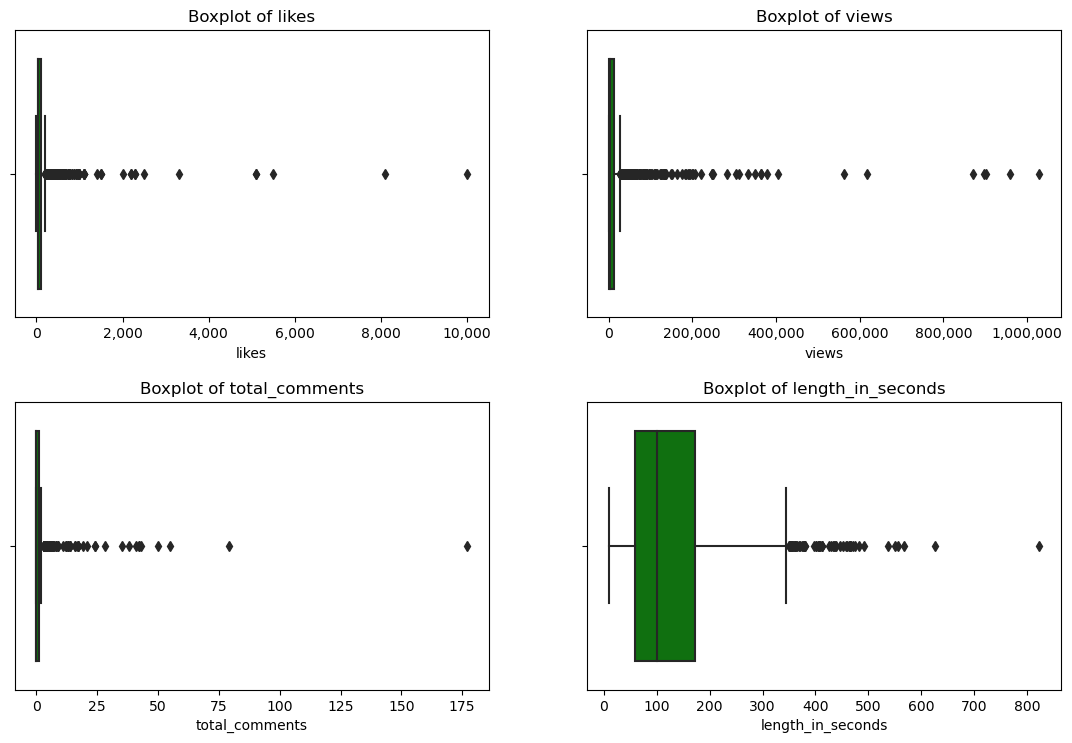

In [93]:
#Distribution of numerical variable
#This dataset has outliers
numeric_cols = ['likes', 'views', 'total_comments', 'length_in_seconds']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.tight_layout(pad=4)

for ax, col in zip(axes.flat, numeric_cols):
    sns.boxplot(x=df_final[col], color='green', ax=ax)
    ax.set_title(f'Boxplot of {col}')
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))  # No scientific notation, commas
    ax.set_xlabel(col)

plt.show()

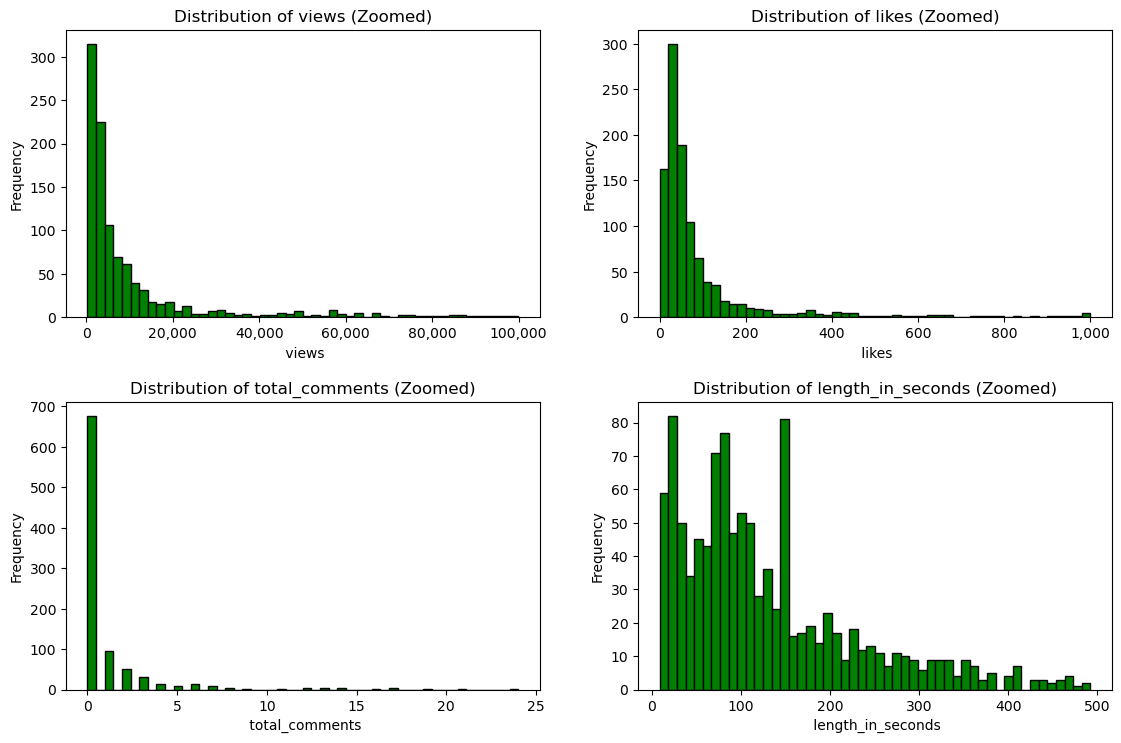

In [98]:
#Zoom more in the distribution
# Define thresholds
thresholds = {'views': 100000, 'likes': 1000, 'total_comments': 25, 'length_in_seconds': 500}
numeric_cols = ['views', 'likes', 'total_comments', 'length_in_seconds']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.tight_layout(pad=4)

for ax, col in zip(axes.flat, numeric_cols):
    data = df_final[df_final[col] <= thresholds.get(col, df_final[col].max())][col]
    ax.hist(data, bins=50, edgecolor='black', color='green')
    ax.set_title(f'Distribution of {col} (Zoomed)')
    ax.set_xlabel(f' {col}')
    ax.set_ylabel('Frequency')

    # Format x-axis ticks with commas, no scientific notation
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))


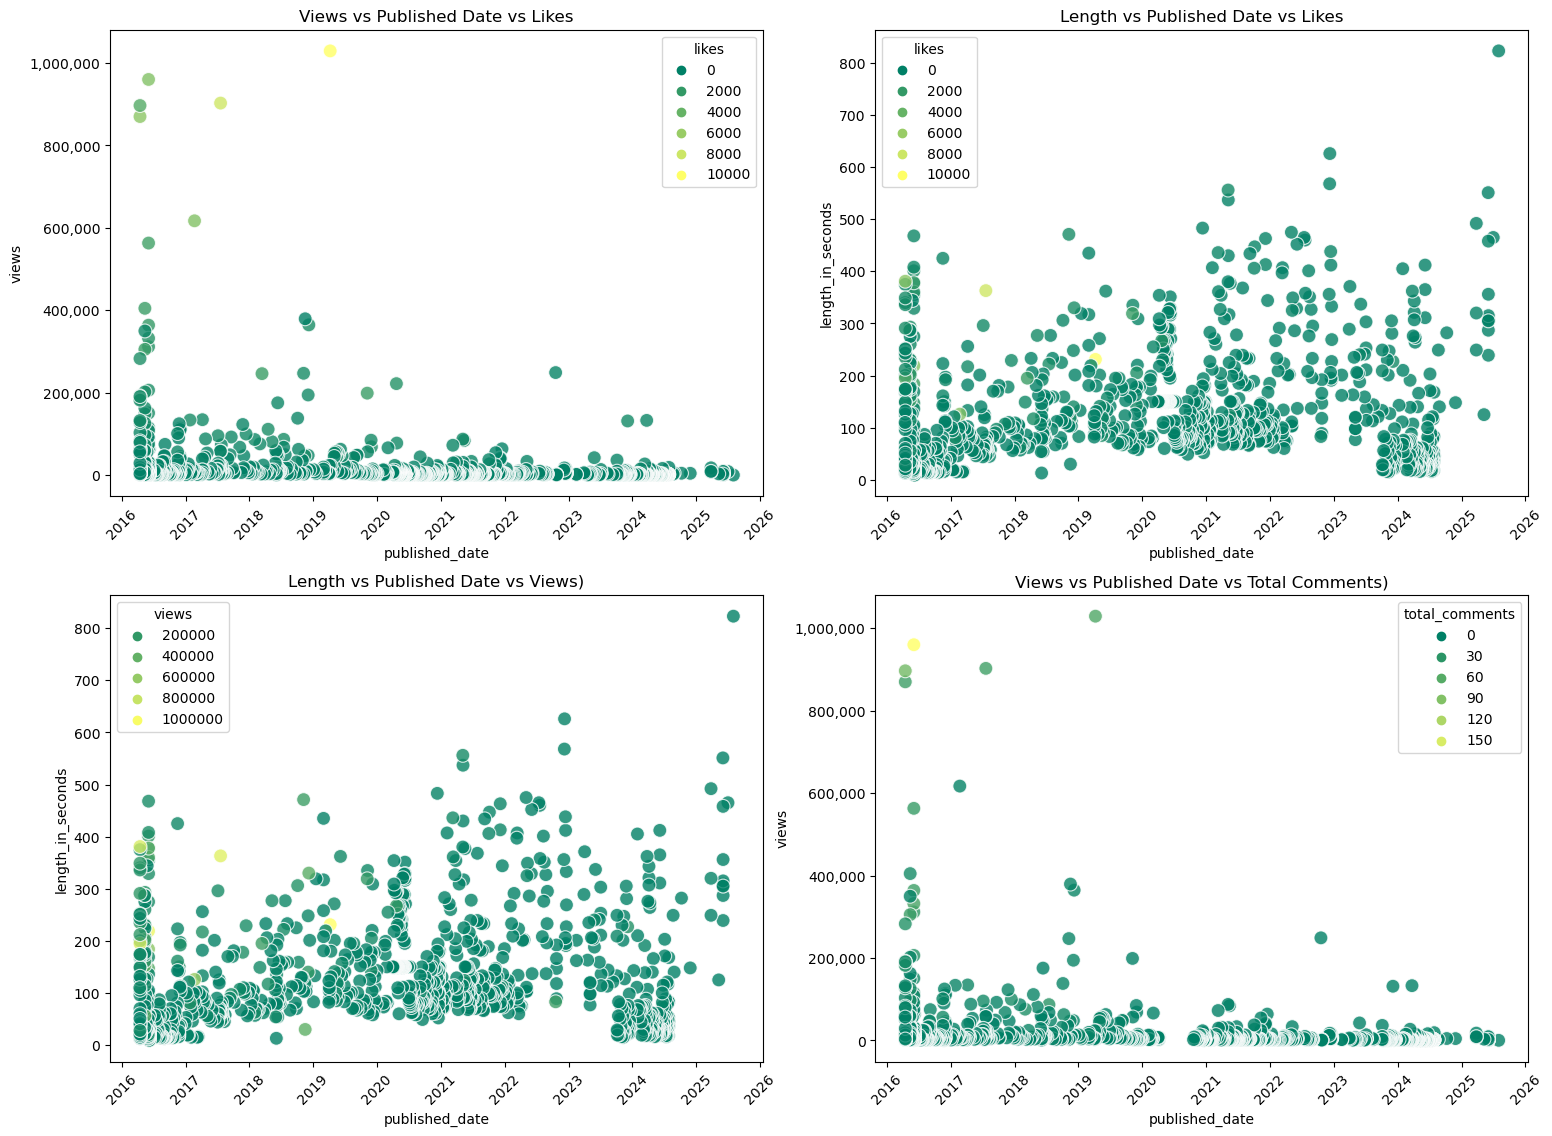

In [107]:
#TREND ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.tight_layout(pad=5)

# Plot 1
sns.scatterplot(x='published_date', y='views', hue='likes', palette='summer', data=df_final, s=100, ax=axes[0, 0], alpha=0.8)
axes[0, 0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_title('Views vs Published Date vs Likes')

# Plot 2
sns.scatterplot(x='published_date', y='length_in_seconds', hue='likes', palette='summer', data=df_final, s=100, ax=axes[0, 1], alpha=0.8)
axes[0, 1].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_title('Length vs Published Date vs Likes')

# Plot 3
sns.scatterplot(x='published_date', y='length_in_seconds', hue='views', palette='summer', data=df_final, s=100, ax=axes[1, 0], alpha=0.8)
axes[1, 0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_title('Length vs Published Date vs Views)')

# Plot 4
sns.scatterplot(x='published_date', y='views', hue='total_comments', palette='summer', data=df_final, s=100, ax=axes[1, 1], alpha=0.8)
axes[1, 1].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_title('Views vs Published Date vs Total Comments)')

plt.show()

In [111]:
#List top 10 video has highest :
for col in numeric_cols:
    print(f"\nTop 10 videos by '{col}':")
    display(df_final.sort_values(by=col, ascending=False).head(10)[['title', 'views','likes','total_comments', 'published_date', 'length']])


Top 10 videos by 'views':


,title,views,likes,total_comments,published_date,length
692,The Perfect Baked New York Cheesecake,1029200,10000,55,2019-04-08,3:51
973,Best-ever Scrambled Eggs | Cook with Curtis St...,959944,5100,177,2016-06-03,3:39
803,How to Make Curtis' Granny's Cottage Pie | Coo...,902615,8100,43,2017-07-20,6:03
1061,How to Make Crunchy Crackling Pork Roast | Coo...,896700,3300,79,2016-04-15,3:15
1042,How to Make Amazing Pumpkin Soup (Super Easy) ...,869951,5500,42,2016-04-15,6:21
846,How to make classic quiche Lorraine,617055,5100,3,2017-02-21,2:06
972,How to Fry the Perfect Eggs | Cook with Curtis...,563091,2500,38,2016-06-03,3:04
1017,Cook Tasty Lamb Chops like a Chef | Cook with ...,404785,2300,14,2016-05-13,2:33
713,Coles Christmas 2018,379412,75,5,2018-11-16,0:30
708,Best-Ever Glazed Ham | Cook with Curtis Stone ...,364615,1000,7,2018-12-07,5:30



Top 10 videos by 'likes':


,title,views,likes,total_comments,published_date,length
692,The Perfect Baked New York Cheesecake,1029200,10000,55,2019-04-08,3:51
803,How to Make Curtis' Granny's Cottage Pie | Coo...,902615,8100,43,2017-07-20,6:03
1042,How to Make Amazing Pumpkin Soup (Super Easy) ...,869951,5500,42,2016-04-15,6:21
973,Best-ever Scrambled Eggs | Cook with Curtis St...,959944,5100,177,2016-06-03,3:39
846,How to make classic quiche Lorraine,617055,5100,3,2017-02-21,2:06
1061,How to Make Crunchy Crackling Pork Roast | Coo...,896700,3300,79,2016-04-15,3:15
972,How to Fry the Perfect Eggs | Cook with Curtis...,563091,2500,38,2016-06-03,3:04
764,No-cook Tim Tam cheesecake,246317,2300,NaN,2018-03-14,3:15
1017,Cook Tasty Lamb Chops like a Chef | Cook with ...,404785,2300,14,2016-05-13,2:33
651,Christmas Pavlova Trifle | Cook with Curtis St...,199037,2200,0,2019-11-06,5:19



Top 10 videos by 'total_comments':


,title,views,likes,total_comments,published_date,length
973,Best-ever Scrambled Eggs | Cook with Curtis St...,959944,5100,177,2016-06-03,3:39
1061,How to Make Crunchy Crackling Pork Roast | Coo...,896700,3300,79,2016-04-15,3:15
692,The Perfect Baked New York Cheesecake,1029200,10000,55,2019-04-08,3:51
974,How to Soft Boil Eggs | Cook with Curtis Stone...,332194,1500,50,2016-06-03,2:27
803,How to Make Curtis' Granny's Cottage Pie | Coo...,902615,8100,43,2017-07-20,6:03
1042,How to Make Amazing Pumpkin Soup (Super Easy) ...,869951,5500,42,2016-04-15,6:21
966,Easy Beef & Veggie Pasties | Cook with Curtis ...,363943,2000,42,2016-06-03,6:18
1026,How to Make your Own Potato Chips at Home | Co...,305256,2200,41,2016-05-13,3:22
972,How to Fry the Perfect Eggs | Cook with Curtis...,563091,2500,38,2016-06-03,3:04
965,Best-ever Roast Chicken | Cook with Curtis Sto...,311683,1500,35,2016-06-03,6:00



Top 10 videos by 'length_in_seconds':


,title,views,likes,total_comments,published_date,length
0,Curtis Stone’s Ultimate Steak Guide | Cook wit...,378,23,0,2025-08-01,13:43
241,Christmas Berries & Cherry Chocolate Ice Cream...,14531,124,0,2022-12-09,10:26
242,The Best Cherry Bourbon Pecan Pie | Cook with ...,17534,117,0,2022-12-08,9:28
395,Lamb Ragu with Potato Gnocchi | Cook with Curt...,87481,676,0,2021-05-06,9:16
10,Christian Petracca’s Steak Tacos | What’s for ...,2576,53,0,2025-06-02,9:11
393,BBQ Pulled Pork with Slaw & Bacon Cornbread | ...,31154,120,0,2021-05-07,8:57
14,Curtis Stone’s best-ever cheesecake | Cook wit...,9246,119,0,2025-03-26,8:12
453,How to Roast a Turkey | Cook with Curtis Stone...,23591,123,0,2020-12-11,8:03
271,Spiced Pear Upside-Down Caramel Tart | Cook wi...,13771,139,0,2022-05-03,7:55
716,Christmas Peach & Mascarpone Smashed Pavlova |...,247201,919,6,2018-11-07,7:51


## PART IV (EXTENDED): PULL OUT COMMENT DATASET FOR POWER BI PURPOSE

In [19]:
data = pd.read_csv('Coles_Videos')
data

,title,link_video,views,published_date,likes,total_comments,length,length_in_seconds
0,Curtis Stone’s Ultimate Steak Guide | Cook wit...,https://www.youtube.com/watch?v=Hgyr8NME5x8&pp...,378,2025-08-01,23,0.0,13:43,823
1,Chrissie Swan’s green chicken | What’s for Din...,https://www.youtube.com/watch?v=JPa4vWKZiEw,8925,2025-07-01,73,NaN,7:45,465
2,Curtis Stone’s best ever lasagne | Cook with C...,https://www.youtube.com/watch?v=PCQus_d0dmw,9449,2025-06-03,168,NaN,7:38,458
3,Curtis Stone’s best ever eggplant parmigiana |...,https://www.youtube.com/watch?v=UkEmBnwCnUo&pp...,1863,2025-06-03,26,0.0,5:56,356
4,Curtis Stone’s best ever beef burger | Cook wi...,https://www.youtube.com/watch?v=beJE0aJhPeU,9822,2025-06-03,80,0.0,3:59,239
...,...,...,...,...,...,...,...,...
1077,Homemade Apple Chips in the Oven | Cook with C...,https://www.youtube.com/watch?v=uamT7M-gwsU,13142,2016-04-15,82,2.0,0:41,41
1078,A Chef's Guide on How to Use a Mandoline | Coo...,https://www.youtube.com/watch?v=m21TQUx3eRg,29346,2016-04-15,108,1.0,2:54,174
1079,How to Make a Lattice Pie Crust | Cook with Cu...,https://www.youtube.com/watch?v=P7oIkbAsxig,3428,2016-04-15,24,2.0,0:51,51
1080,AT HOME WITH COLES,https://www.youtube.com/watch?v=UbPzoXkcdmw,79653,2016-04-15,343,3.0,0:28,28


In [22]:
#ONLY CARE WHERE WE HAVE COMMENTS
f_data = data[(data['total_comments'].notna()) & (data['total_comments'] > 0)]
f_data

,title,link_video,views,published_date,likes,total_comments,length,length_in_seconds
661,How To Make Mango & Blackberry Yoghurt Ice Blo...,https://www.youtube.com/watch?v=KaXu3ndAmCQ,48939,2019-09-09,546,13.0,1:07,67
662,BBQ Prawns With Mango Mayonnaise,https://www.youtube.com/watch?v=YBKRrMTjzCQ,48475,2019-09-09,258,4.0,1:15,75
684,Condensed milk cheesecake slice,https://www.youtube.com/watch?v=ROw4XEUd5Bw,44431,2019-05-14,876,1.0,1:25,85
685,How to make Frozen Tiramisu | Simple Summer De...,https://www.youtube.com/watch?v=Cg3M03qvszM,56489,2019-05-10,314,1.0,1:39,99
686,How to make osso bucco with smashed potatoes,https://www.youtube.com/watch?v=iBOrpSBZg3Q,53376,2019-05-03,445,7.0,2:21,141
...,...,...,...,...,...,...,...,...
1077,Homemade Apple Chips in the Oven | Cook with C...,https://www.youtube.com/watch?v=uamT7M-gwsU,13142,2016-04-15,82,2.0,0:41,41
1078,A Chef's Guide on How to Use a Mandoline | Coo...,https://www.youtube.com/watch?v=m21TQUx3eRg,29346,2016-04-15,108,1.0,2:54,174
1079,How to Make a Lattice Pie Crust | Cook with Cu...,https://www.youtube.com/watch?v=P7oIkbAsxig,3428,2016-04-15,24,2.0,0:51,51
1080,AT HOME WITH COLES,https://www.youtube.com/watch?v=UbPzoXkcdmw,79653,2016-04-15,343,3.0,0:28,28


In [39]:
#GET GENERAL INFO FOR VIDEOS
def scroll_to_bottom(driver):
    # Scroll a little bit once to trigger comment loading
    driver.execute_script("window.scrollTo(0, 500);")
    sleep(5)

    last_height = driver.execute_script("return document.documentElement.scrollHeight")

    while True:
        # Scroll to bottom
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        sleep(5)
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

video_f_data = []
count = 0  # Counter for successfully processed videos

for link in f_data['link_video']:
    try:
        driver.get(link)
        sleep(5)

        scroll_to_bottom(driver)

        try:
            name_elems = driver.find_elements(By.CSS_SELECTOR, '#author-text > span')
            names = [elem.text for elem in name_elems]
        except Exception:
            names = []

        try:
            content_elems = driver.find_elements(By.CSS_SELECTOR, '#content-text')
            contents = [elem.text for elem in content_elems]
        except Exception:
            contents = []

        for n, c in zip(names, contents):
            video_f_data.append({
                'link': link,
                'name_comment': n,
                'content_comment': c
            })

        count += 1  # Increment only after successful scraping

    except ElementNotInteractableException:
        print(f"ElementNotInteractableException encountered at link {link}, stopping loop.")
        break  # Stop processing further videos
    except Exception as e:
        print(f"Error for {link}: {e}")
        continue

print(f"Total videos processed before stopping: {count}")

comment_data = pd.DataFrame(video_f_data)


Total videos processed before stopping: 260


In [41]:
comment_data.to_csv('Coles_Comments', index=False)

In [45]:
comment_data = pd.read_csv('Coles_Comments')
comment_data 

,link,name_comment,content_comment
0,https://www.youtube.com/watch?v=KaXu3ndAmCQ,@gachasmileydiya5378,I love to see you guys make these!I will defin...
1,https://www.youtube.com/watch?v=KaXu3ndAmCQ,@Rohitbatra12345,That looks good
2,https://www.youtube.com/watch?v=KaXu3ndAmCQ,@_theycallmeartist_,yum
3,https://www.youtube.com/watch?v=KaXu3ndAmCQ,@originalgoldengoddess,Yummmmmmm
4,https://www.youtube.com/watch?v=KaXu3ndAmCQ,@aidandsouza2005,I made the same with orange and grape fruit wi...
...,...,...,...
1185,https://www.youtube.com/watch?v=P7oIkbAsxig,@chrisnaida2012,omg im going crazy watching this. tq for the t...
1186,https://www.youtube.com/watch?v=P7oIkbAsxig,@mengyap8560,so pretty!
1187,https://www.youtube.com/watch?v=UbPzoXkcdmw,@livingroomproductions2456,It All Counts
1188,https://www.youtube.com/watch?v=UbPzoXkcdmw,@selvinguzmanguzman9930,Hi
